#Introduction

The below project is to build a shot chart of the Pacers 2023-2024 Season from a kaggle dataset with shot information. At the bottom of the workbook the final shot chart can be viewed.


Using Colab cache for faster access to the 'nba-shots' dataset.


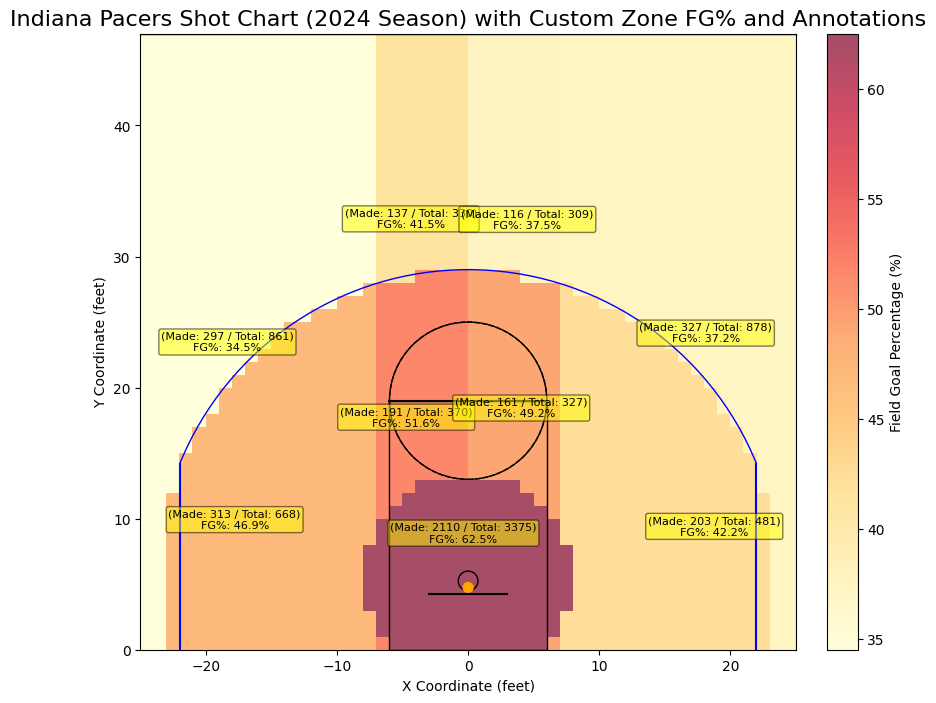

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import kagglehub

# --- 1. Data Loading and Initial Cleaning ---
# Download latest version of dataset
path = kagglehub.dataset_download("mexwell/nba-shots")
csv_file_path = os.path.join(path, 'NBA_2024_Shots.csv')
df_2024 = pd.read_csv(csv_file_path)

# Filter for Indiana Pacers and select relevant columns
df_indiana_pacers = df_2024[df_2024['TEAM_NAME'] == 'Indiana Pacers']
selected_columns = ['LOC_X', 'LOC_Y', 'SHOT_MADE', 'SHOT_TYPE', 'PLAYER_NAME', 'TEAM_NAME', 'SHOT_DISTANCE']
df_shots_cleaned = df_indiana_pacers[selected_columns].copy()

# Add 'POINTS' column
df_shots_cleaned.loc[:, 'POINTS'] = df_shots_cleaned['SHOT_TYPE'].apply(lambda x: 3 if x == '3PT Field Goal' else 2)

# --- 2. Define NBA Court Geometry (Re-calibrated) ---
nba_court_dimensions = {
    'basket': (0, 5.25),
    'rim': (0, 4.75),
    'backboard': (0, 4.25),
    'free_throw_line_y': 19,
    'three_point_arc_radius': 23.75,
    'three_point_corner_x_offset': 22,
    'key_width': 12,
    'key_length': 19
}

# Calculate correct three_point_corner_y using Pythagorean theorem
basket_y = nba_court_dimensions['basket'][1]
three_point_arc_radius = nba_court_dimensions['three_point_arc_radius']
three_point_corner_x_offset = nba_court_dimensions['three_point_corner_x_offset']
calculated_three_point_corner_y = basket_y + np.sqrt(three_point_arc_radius**2 - three_point_corner_x_offset**2)
nba_court_dimensions['three_point_corner_y'] = calculated_three_point_corner_y

# --- 3. Redefine `draw_court` Function ---
def draw_court(ax):
    basket_x, basket_y = nba_court_dimensions['basket']
    rim_x, rim_y = nba_court_dimensions['rim']
    backboard_x, backboard_y = nba_court_dimensions['backboard']
    free_throw_line_y = nba_court_dimensions['free_throw_line_y']
    three_point_arc_radius = nba_court_dimensions['three_point_arc_radius']
    three_point_corner_y = nba_court_dimensions['three_point_corner_y']
    three_point_corner_x_offset = nba_court_dimensions['three_point_corner_x_offset']
    key_width = nba_court_dimensions['key_width']
    key_length = nba_court_dimensions['key_length']

    # Basket, Rim, Backboard
    ax.add_patch(plt.Circle((basket_x, basket_y), 0.75, color='black', fill=False))
    ax.add_patch(plt.Circle((rim_x, rim_y), 0.75 / 2, color='orange'))
    ax.add_line(plt.Line2D((backboard_x - 3, backboard_x + 3), (backboard_y, backboard_y), color='black'))

    # Free-throw lane (paint)
    ax.add_patch(plt.Rectangle((-key_width / 2, 0), key_width, key_length, fill=False, edgecolor='black', lw=1))
    ax.add_line(plt.Line2D((-key_width / 2, key_width / 2), (free_throw_line_y, free_throw_line_y), color='black'))
    ax.add_patch(plt.Circle((0, free_throw_line_y), 6, fill=False, edgecolor='black', lw=1))
    ax.add_patch(plt.Circle((0, free_throw_line_y), 6, fill=False, edgecolor='black', lw=1, linestyle='dashed'))

    # Three-point line
    ax.add_line(plt.Line2D((-three_point_corner_x_offset, -three_point_corner_x_offset), (0, three_point_corner_y), color='blue'))
    ax.add_line(plt.Line2D((three_point_corner_x_offset, three_point_corner_x_offset), (0, three_point_corner_y), color='blue'))

    y_offset_from_basket = three_point_corner_y - basket_y
    theta_right_rad = np.arctan2(y_offset_from_basket, three_point_corner_x_offset)
    theta_right_deg = np.degrees(theta_right_rad)
    theta_left_rad = np.arctan2(y_offset_from_basket, -three_point_corner_x_offset)
    theta_left_deg = np.degrees(theta_left_rad)

    ax.add_patch(patches.Arc((basket_x, basket_y), three_point_arc_radius * 2, three_point_arc_radius * 2, angle=0,
                           theta1=theta_right_deg, theta2=theta_left_deg, color='blue', lw=1))

    # Half-court line
    ax.add_line(plt.Line2D((-25, 25), (47, 47), color='black', lw=1))

    # Set aspect ratio and limits
    ax.set_aspect('equal')
    ax.set_xlim(-25, 25)
    ax.set_ylim(-5, 47)

# --- 4. Define `categorize_shot_for_grid` Function ---
def categorize_shot_for_grid(loc_x, loc_y):
    basket_x, basket_y = nba_court_dimensions['basket']
    three_point_arc_radius = nba_court_dimensions['three_point_arc_radius']
    three_point_corner_y = nba_court_dimensions['three_point_corner_y']
    three_point_corner_x_offset = nba_court_dimensions['three_point_corner_x_offset']

    distance_to_basket = np.sqrt((loc_x - basket_x)**2 + (loc_y - basket_y)**2)

    if distance_to_basket <= 8:
        return 'Inside 8 feet(Center)'

    is_three_pointer = False
    if (loc_y >= three_point_corner_y and abs(loc_x) >= three_point_corner_x_offset) or \
       (distance_to_basket >= three_point_arc_radius):
        is_three_pointer = True

    horizontal_zone = ''
    if loc_x < -7.5:
        horizontal_zone = 'left side'
    elif loc_x >= -7.5 and loc_x < 0:
        horizontal_zone = 'left side center'
    elif loc_x >= 0 and loc_x < 7.5:
        horizontal_zone = 'right side center'
    else:
        horizontal_zone = 'right side'

    if is_three_pointer:
        return f"{horizontal_zone} 3pt"
    else:
        return f"{horizontal_zone} 2pt"

# --- 5. Recalculate Shooting Statistics per Custom Zone ---
df_shots_cleaned['CUSTOM_ZONE'] = df_shots_cleaned.apply(lambda row: categorize_shot_for_grid(row['LOC_X'], row['LOC_Y']), axis=1)

df_custom_zone_stats = df_shots_cleaned.groupby('CUSTOM_ZONE').agg(
    total_shots=('SHOT_MADE', 'size'),
    made_shots=('SHOT_MADE', lambda x: x.sum()),
    missed_shots=('SHOT_MADE', lambda x: (~x).sum())
).reset_index()

df_custom_zone_stats['FG%'] = (df_custom_zone_stats['made_shots'] / df_custom_zone_stats['total_shots'] * 100).round(1)

df_custom_zone_stats['made_missed_annotation'] = df_custom_zone_stats.apply(
    lambda row: f"(Made: {int(row['made_shots'])} / Total: {int(row['total_shots'])})\nFG%: {row['FG%']:.1f}%",
    axis=1
)

# --- 6. Generate Grid with Custom Zone Assignments and FG% ---
custom_zone_centroids = df_shots_cleaned.groupby('CUSTOM_ZONE')[['LOC_X', 'LOC_Y']].mean().reset_index()
df_custom_zone_annotations = pd.merge(df_custom_zone_stats, custom_zone_centroids, on='CUSTOM_ZONE')

x_min, x_max = -25, 25
y_min, y_max = 0, 47
x_bins = (x_max - x_min)
y_bins = (y_max - y_min)

x_coords = np.linspace(x_min, x_max, x_bins)
y_coords = np.linspace(y_min, y_max, y_bins)
X, Y = np.meshgrid(x_coords, y_coords)

fg_percentage_grid = np.zeros(X.shape)
fg_percent_map = dict(zip(df_custom_zone_stats['CUSTOM_ZONE'], df_custom_zone_stats['FG%']))

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        loc_x_grid = X[i, j]
        loc_y_grid = Y[i, j]
        custom_zone = categorize_shot_for_grid(loc_x_grid, loc_y_grid)
        fg_percentage_grid[i, j] = fg_percent_map.get(custom_zone, 0.0)

# --- 7. Generate Final Shotchart with Adjusted Annotations ---
plt.figure(figsize=(10, 8))
ax = plt.gca()

draw_court(ax)

extent = [x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()]

img = ax.imshow(fg_percentage_grid, origin='lower', extent=extent, cmap='YlOrRd', alpha=0.7)

cbar = plt.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Field Goal Percentage (%)')

annotation_offsets = {
    'Inside 8 feet(Center)': (0, 15),
    'left side 2pt': (-15, 0),
    'left side 3pt': (-15, 0),
    'left side center 2pt': (-10, 10),
    'left side center 3pt': (-10, 10),
    'right side 2pt': (15, 0),
    'right side 3pt': (15, 0),
    'right side center 2pt': (10, 10),
    'right side center 3pt': (10, 10)
}

for index, row in df_custom_zone_annotations.iterrows():
    zone = row['CUSTOM_ZONE']
    offset_x, offset_y = annotation_offsets.get(zone, (0, 0))
    ax.annotate(
        row['made_missed_annotation'],
        (row['LOC_X'], row['LOC_Y']),
        textcoords="offset points",
        xytext=(offset_x, offset_y),
        ha='center', va='center',
        fontsize=8, color='black', bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.5)
    )

ax.set_title('Indiana Pacers Shot Chart (2024 Season) with Custom Zone FG% and Annotations', fontsize=16)
ax.set_xlabel('X Coordinate (feet)')
ax.set_ylabel('Y Coordinate (feet)')
ax.set_ylim(0, 47)
plt.show()

#Summary

From the above shot chart of the Pacers 2023-24 Season the amount of shots made and attempted as well as the FG% can be seen for 9 sections on the court. Something that stands out is that there were substantially more shots taken from 2pt from the left side of the court than the right side of the court as well as being shot at a noticeably higher percentage. It can be generally hypothesized that players were more comfortable driving with their right hand to the left side of the court for mid-range shots.